In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import os

from adaptable import AdaptableNet

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.set_device(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Set seed properly
np.random.seed(1)
torch.manual_seed(1)

# Create the AdaptableNet
test_net = AdaptableNet(device, 12, 5, hidden_size=[7, 10]).to(device)
# Create some fake data
test_data = torch.Tensor(np.random.random((4, 12))).to(device)
# Generate some fake output
test_output = test_net(test_data)

# Increase the size of the first hidden layer of the net
test_net.increase_hidden_size(0)

print("Difference After Increase 1:", torch.norm(test_output - test_net(test_data)))

# Immediately decrease the size of the first hidden layer of the net 
# Note: this first decrease will be a trivial operation since we are just undoing the increase from above
test_net.decrease_hidden_size(0)

print("Difference After Decrease 1:", torch.norm(test_output - test_net(test_data)))

# Decrease the size of the first hidden layer of the net AGAIN. 
# This will be a nontrivial decrease, as it has to get rid of some nonzero weights
test_net.decrease_hidden_size(0)

print("Difference After Decrease 2:", torch.norm(test_output - test_net(test_data)))

Difference After Increase 1: tensor(0., device='cuda:0', grad_fn=<CopyBackwards>)
Difference After Decrease 1: tensor(0., device='cuda:0', grad_fn=<CopyBackwards>)
Difference After Decrease 2: tensor(0.0399, device='cuda:0', grad_fn=<CopyBackwards>)


Experiment 1: Seeing what method of decreasing the hidden size is in general best. May need to come back to try new methods of doing this since the current methods are very heuristic.

In [6]:
# Will store our "losses" for each mode
losses = np.zeros((4, 1000))

# For different seeds
for i in range(1000):
    # For each mode
    for mode in range(4):
        # Set the seeds
        np.random.seed(i)
        torch.manual_seed(i)
        # Initialize Net
        test_net = AdaptableNet(device, 12, 5, hidden_size=[10,])
        # Generate data
        test_data = torch.Tensor(np.random.random((4, 12))).to(device)
        # Generate output
        test_output = test_net(test_data)
        # Decrease the size
        test_net.decrease_hidden_size(0, mode=mode)
        # Compute the norm of the difference in the output
        losses[mode, i] = torch.norm(test_output - test_net(test_data))
        
means = np.mean(losses, axis=1)
print("Method 0 avg. loss:", means[0])
print("Method 1 avg. loss:", means[1])
print("Method 2 avg. loss:", means[2])
print("Method 3 avg. loss:", means[3])

Method 0 avg. loss: 0.3508608553572558
Method 1 avg. loss: 0.08565819954313338
Method 2 avg. loss: 0.08222294467076427
Method 3 avg. loss: 0.35852245862683046


Experiment #2 Training an Adaptable Net with random increasing/decreasing of the network

In [7]:
from torchvision.datasets import MNIST, EMNIST, QMNIST, KMNIST, FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [8]:
# Tensorize everything
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])
# Load QMNIST (digits)
train_data = QMNIST('./data/', download=True, train=True, transform=tensor_transform)
test_data = QMNIST('./data/', download=True, train=False, transform=tensor_transform)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True, num_workers=2)

In [10]:
model = AdaptableNet(device, 784, 10, hidden_size=[128, 32]).to(device)

# Loss and optimizer
criterion = nn.NLLLoss() #You can modify the loss function
optimizer = optim.Adam(model.parameters(), lr=0.01) #You can change the optimizer

num_epochs = 25
teststep =  50


# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
test_acc = []
increases = [0, 0]
decreases = [0, 0]

for epoch in range(num_epochs):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):

        images = images.cuda(non_blocking=True) #Transfer images to GPU
        labels = labels.cuda(non_blocking=True) #Transfer labels to GPU
        images = images.reshape((images.shape[0], images.shape[2] * images.shape[3]))

        images = Variable(images)
        labels = Variable(labels)
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

         # Track the accuracy
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % teststep == 0:
            w = torch.nn.utils.parameters_to_vector(model.parameters())
            correct_test = 0
            total_test = 0
            for images_test, labels_test in test_loader:
                images_test = images_test.cuda(non_blocking=True)
                labels_test = labels_test.cuda(non_blocking=True)
                images_test = images_test.reshape((images_test.shape[0], images_test.shape[2] * images_test.shape[3]))
                images_test = Variable(images_test)
                labels_test = Variable(labels_test)

                outputs_test = model(images_test)
                _, predicted_test = torch.max(outputs_test.data, 1)
                total_test += labels_test.size(0)
                correct_test += (predicted_test == labels_test).sum().item()
            # Don't print test accuracy, but use the results to plot the data
            test_acc.append(correct_test/total_test)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
            
            # Now we change the model
            # Start by just doing this randomly
            r = np.random.random()
            
            if r < 0.2:
                if np.random.random() < 0.5:
                    model.increase_hidden_size(0)
                    increases[0] += 1
                    print(increases, decreases)
                else:
                    model.increase_hidden_size(1)
                    increases[1] += 1
                    print(increases, decreases)
            elif r < 0.4:
                if np.random.random() < 0.5:
                    model.decrease_hidden_size(0)
                    decreases[0] += 1
                    print(increases, decreases)
                else:
                    model.decrease_hidden_size(1)
                    decreases[1] += 1
                    print(increases, decreases)
                
    acc_list.append(correct / total)
    if (total == correct):4
        break

Epoch [1/25], Step [50/235], Loss: 0.2152, Accuracy: 81.87%
Epoch [1/25], Step [100/235], Loss: 0.2164, Accuracy: 86.95%
Epoch [1/25], Step [150/235], Loss: 0.2872, Accuracy: 89.40%
[0, 1] [0, 0]
Epoch [1/25], Step [200/235], Loss: 0.2067, Accuracy: 90.82%
[0, 2] [0, 0]
Epoch [2/25], Step [50/235], Loss: 0.1502, Accuracy: 96.61%
Epoch [2/25], Step [100/235], Loss: 0.1039, Accuracy: 96.68%
[0, 2] [0, -1]
Epoch [2/25], Step [150/235], Loss: 0.0577, Accuracy: 96.73%
[0, 2] [0, -2]
Epoch [2/25], Step [200/235], Loss: 0.0854, Accuracy: 96.78%
Epoch [3/25], Step [50/235], Loss: 0.0520, Accuracy: 97.74%
[0, 3] [0, -2]
Epoch [3/25], Step [100/235], Loss: 0.0553, Accuracy: 97.78%
Epoch [3/25], Step [150/235], Loss: 0.0470, Accuracy: 97.75%
[0, 3] [-1, -2]
Epoch [3/25], Step [200/235], Loss: 0.0749, Accuracy: 97.55%
Epoch [4/25], Step [50/235], Loss: 0.0493, Accuracy: 98.09%
[0, 3] [-2, -2]
Epoch [4/25], Step [100/235], Loss: 0.1134, Accuracy: 98.09%
[1, 3] [-2, -2]
Epoch [4/25], Step [150/235],

Text(0, 0.5, 'Percentage Accuracy')

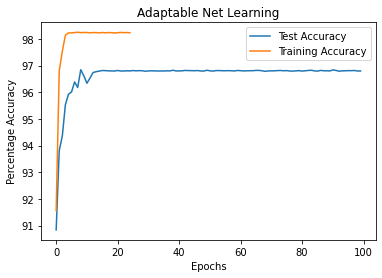

In [11]:
plt.plot(range(len(test_acc)),[x * 100 for x in test_acc],label='Test Accuracy')
plt.plot(range(len(acc_list)),[x * 100 for x in acc_list],label='Training Accuracy')
plt.legend()
plt.title("Adaptable Net Learning")
plt.xlabel('Epochs')
plt.ylabel('Percentage Accuracy')

In [30]:
np.random.random()

0.5498952283806315